In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import batman
import random
from astropy.io import ascii
from scipy import constants

In [2]:
#Define constants
M_sun = 1.989e+30
R_sun = 695700000
R_Earth = 6378100
day = 86400
AU = 1.496e+11

In [3]:
def planetmaker(rates, radius_low, radius_up, period_low, period_up):
    '''Generates parameters for a given number of planets in a planetary system from occurence rates'''
    rowdex = np.arange(len(rates))
    cosi = np.random.random_sample()
    anglew = np.random.uniform(low=-180., high=180.)
    e = np.random.beta(a=1.03, b=13.6)
    rows = np.random.choice(rowdex, p=rates)
    radp = np.random.uniform(low=radius_low[rows], high=radius_up[rows])
    per = np.random.uniform(low=period_low[rows], high=period_up[rows])
    return radp, per, cosi, anglew, e

In [4]:
table = ascii.read('norm_rates_FGK.csv', format='csv', header_start=0, data_start=1)
occ = np.array(table['f'], dtype=float)
radbinlower = np.array(table['rmin'], dtype=float)
radbinupper = np.array(table['rmax'], dtype=float)
pbinlower = np.array(table['pmin'], dtype=float)
pbinupper = np.array(table['pmax'], dtype=float)

In [19]:
#Generate a random temperature. In the final pipeline Temperature will be chosen from TICv8
T_eff = np.random.uniform(3700.0, 7500.0)

In [20]:
#Assign spectral type based on temperature
if 7500<= T_eff <10000:
    spectral_type = 'A'
if 6000<= T_eff <7500:
    spectral_type = 'F'
if 5200<= T_eff <6000:
    spectral_type = 'G'
if 3700<= T_eff < 5200:
    spectral_type = 'K'
if 2400<= T_eff < 3700:
    spectral_type = 'M'

In [21]:
#Choose mass and radius dependent on spectral type. In the final pipeline these will come from TICv8
if spectral_type == 'A':
    M_star = np.random.uniform(2.1, 1.4)
    R_star = np.random.uniform(1.4, 1.8)
if spectral_type == 'F':
    M_star = np.random.uniform(1.04, 1.4)
    R_star = np.random.uniform(1.15, 1.4)
if spectral_type == 'G':
    M_star = np.random.uniform(0.8, 1.04)
    R_star = np.random.uniform(0.96, 1.15)
if spectral_type == 'K':
    M_star = np.random.uniform(0.45, 0.8)
    R_star = np.random.uniform(0.7, 0.96)
if spectral_type == 'M':
    M_star = np.random.uniform(0.08, 0.45)
    R_star = np.random.uniform(0.1, 0.8)

In [22]:
radius, period, cosi, peri, ecc = planetmaker(occ, radbinlower, radbinupper, pbinlower, pbinupper)

In [23]:
#Overwrite cosi so that planet always transits
cosi=0

In [24]:
a = np.cbrt((constants.G*(M_star*M_sun)*np.square(period*day))/(4*np.square(np.pi)))
b = ((a*np.square(cosi))/(R_star*R_sun))*((1-np.square(ecc))/(1+ecc*np.sin(peri)))
k = (radius*R_Earth)/(R_star*R_sun)
Transit = (0<= b) & (b< 1)
Grazing = (b >= 1) & (b < (1+k))
inc = np.degrees(np.arccos(cosi))

In [25]:
if Transit == True:
    #Generate range of Time values to test for in/out transit times in TESS BJD, assuming a mission duration of 10 years and a cadence of 20s
    T_start = 0.0
    T_end = 3650.0
    cadence = 20.0
    T_range = np.arange(T_start, T_end, step=cadence/day, dtype=float)
    #Calculate Transit duration
    T_dur = (period*day/np.pi)*np.arcsin((R_star*R_sun/a)*np.sqrt(1+k-np.square(b))/np.sqrt(1-np.square(cosi)))
    T_0 = np.random.uniform(low=T_start, high=T_start+period) #First possible to observe transit ingress time
    #Generate orbital phase with 0 at T_1
    phi = ((T_range - T_0)%period)/period
    #Use phase to generate simple boolean transit model
    In_transit = (phi >= 0) & (phi <= ((T_dur/day)/period))

In [26]:
print(spectral_type, 'type star')
print('Planet')
print('Radius = ',radius, 'Earth Radii')
print('Period =', period, 'days')
print('Inclination angle =', inc, 'deg')
print('Eccentricity =', ecc)
print('Semi major axis =',a/AU, 'AU')
print('Impact parameter, b =', b)
print('Transit?', Transit)
print('Grazing?', Grazing)
if Transit == True:
    print('Transit duration =', T_dur/3600, 'hours')

F type star
Planet
Radius =  2.238063229704144 Earth Radii
Period = 412.53545804823045 days
Inclination angle = 90.0 deg
Eccentricity = 0.1305556898014454
Semi major axis = 1.1145521336740276 AU
Impact parameter, b = 0.0
Transit? True
Grazing? False
Transit duration = 16.21722595570722 hours


<IPython.core.display.Javascript object>


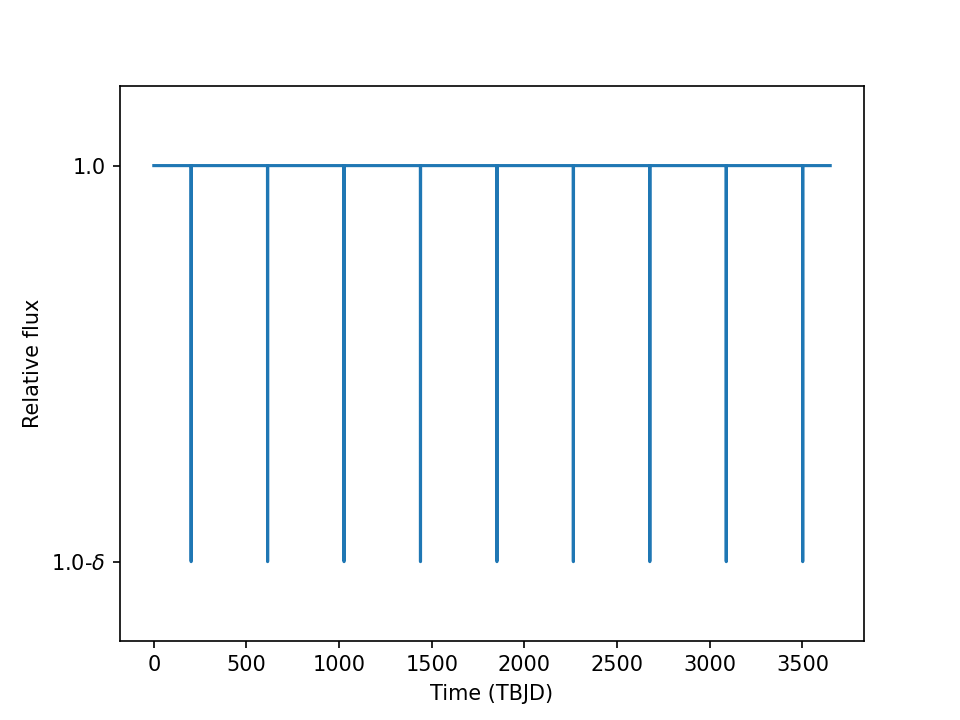

(-0.2, 1.2)

In [27]:
#Plot the simple Boolean In/out transit model
plt.figure(1)
plt.plot(T_range, np.invert(In_transit))
plt.xlabel('Time (TBJD)')
plt.ylabel('Relative flux')
plt.yticks([1.0, 0.0], ['1.0', '1.0-$\delta$'])
plt.ylim(-0.2, 1.2)

In [28]:
#Slightly more complex model with actual transit depth included
f = np.ones_like(T_range)
f[In_transit] = 1-np.square(k)

<IPython.core.display.Javascript object>


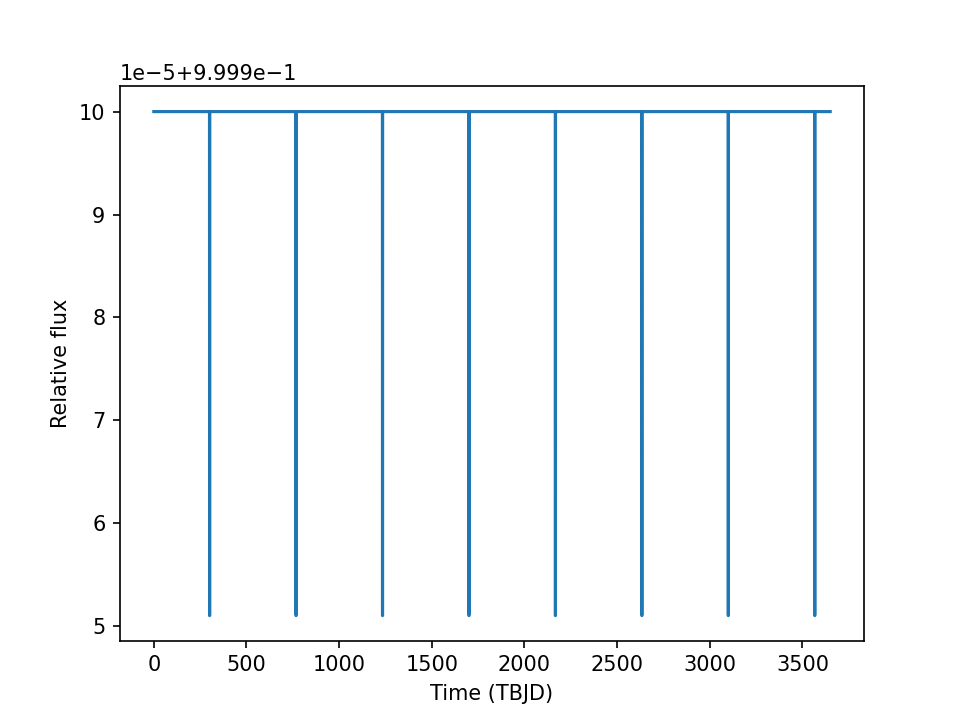

In [18]:
#Plot square transit model with depth
plt.figure(2)
plt.plot(T_range, f)
plt.xlabel('Time (TBJD)')
plt.ylabel('Relative flux')
plt.show()